# Predicting Supermarket Sales
- Andrea Cohen
- 03.22.23

## Data:
- Original data source
https://datahack.analyticsvidhya.com/contest/practice-problem-big-mart-sales-iii/

## Data Dictionary:

Variable Name | Description
---| ---
Item_Identifier| Unique product ID
Item_Weight| Weight of product
Item_Fat_Content| Whether the product is low fat or regular
Item_Visibility| The percentage of total display area of all products in a store allocated to the particular product
Item_Type| The category to which the product belongs
Item_MRP| Maximum Retail Price (list price) of the product
Outlet_Identifier| Unique store ID
Outlet_Establishment_Year| The year in which store was established
Outlet_Size| The size of the store in terms of ground area covered
Outlet_Location_Type| The type of area in which the store is located
Outlet_Type| Whether the outlet is a grocery store or some sort of supermarket
Item_Outlet_Sales| Sales of the product in the particular store. This is the target variable to be predicted.


## Preliminary steps

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import joblib

### Set the random state for reproducibility

In [2]:
SEED = 321
np.random.seed(SEED)

### Set pandas to display more columns


In [3]:
pd.set_option('display.max_columns', 50)

### Suppress scientific notation in pandas

In [4]:
pd.set_option('display.float_format', lambda x: f"{x:,.2f}")

### Custom functions

In [5]:
# for evaluating a regression model using r-squared and RMSE
def evaluate_regression(model, X_train, y_train, X_test, y_test): 
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, squared = False)
    print(f"Training Data:\tR^2= {r2_train:.2f}\tRMSE= {rmse_train:.2f}")
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, squared = False)
    print(f"Test Data:\tR^2= {r2_test:.2f}\tRMSE= {rmse_test:.2f}")

In [6]:
# for annotating hbars
def annotate_hbars(ax, ha = 'left', va = 'center', size = 12, xytext = (4,0),
                  textcoords = 'offset points'):
    for bar in ax.patches:
        bar_ax = bar.get_y() + bar.get_height()/2
        val = bar.get_width()
        if val < 0:
            val_pos = 0
        else:
            val_pos = val
        ax.annotate(f"{val:.3f}", (val_pos, bar_ax), ha = ha, va = va, size = size,
                        xytext = xytext, textcoords = textcoords)

In [7]:
# for plotting coefficients with annotation
def plot_coeffs(coeffs, top_n = None,  figsize = (4,5), 
                intercept = False,  intercept_name = "intercept", 
                annotate = False, ha = 'left', va = 'center', size = 12, 
                xytext = (4,0), textcoords = 'offset points'):
    if (intercept==False) & (intercept_name in coeffs.index):
        coeffs = coeffs.drop(intercept_name)
    if top_n==None:
        plot_vals = coeffs
        title = "All Coefficients"
    else:
        coeff_rank = coeffs.abs().rank().sort_values(ascending = False)
        top_n_features = coeff_rank.head(top_n)
        plot_vals = coeffs.loc[top_n_features.index].sort_values()
        title = f"{top_n} Largest Coefficients"
    ax = plot_vals.plot(kind = 'barh', figsize = figsize)
    ax.set(xlabel = 'Coefficient', ylabel = 'Feature Names', title = title)
    ax.axvline(0, color = 'k')
    if annotate==True:
        annotate_hbars(ax, ha = ha, va = va, size = size, xytext = xytext, textcoords = textcoords)
    return ax

In [8]:
# for feature importance
def get_importances(model, feature_names = None, name = 'Feature Importance', sort = False, ascending = True):
    if feature_names == None:
        feature_names = model.feature_names_in_
    importances = pd.Series(model.feature_importances_, index = feature_names, name = name)
    if sort == True:
        importances = importances.sort_values(ascending = ascending)
    return importances

In [9]:
# for plotting importances
def plot_importance(importances, top_n = None,  figsize = (8,6)):
    if top_n == None:
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"
    ax = plot_vals.plot(kind = 'barh', figsize = figsize)
    ax.set(xlabel = 'Importance', ylabel = 'Feature Names', title = title)
    return ax

### Load the data

In [10]:
df = pd.read_csv('Data/sales_predictions.csv')
display(df.head())
display(df.info())

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.02,Dairy,249.81,OUT049,1999,Medium,Tier 1,Supermarket Type1,"3,735.14"
1,DRC01,5.92,Regular,0.02,Soft Drinks,48.27,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.42
2,FDN15,17.50,Low Fat,0.02,Meat,141.62,OUT049,1999,Medium,Tier 1,Supermarket Type1,"2,097.27"
3,FDX07,19.20,Regular,0.00,Fruits and Vegetables,182.09,OUT010,1998,NaN,Tier 3,Grocery Store,732.38
4,NCD19,8.93,Low Fat,0.00,Household,53.86,OUT013,1987,High,Tier 3,Supermarket Type1,994.71


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


None

### Inspect the data

In [11]:
#how many rows and columns?
df.shape

(8523, 12)

- There are 8523 rows and 12 columns.

In [12]:
#what are the datatypes of each variable?
df.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

- Item_Identifier, Item_Fat_Content, Item_Type, Outlet_Identifier, Outlet_Size, Outlet_Location_Type, and Outlet_Type are all datatype object.
- Item_Weight, Item_Visibility, Item_MRP, and Item_Outlet Sales are all datatype float64.
- Item_Establishment_Year is datatype int64.

In [13]:
display(df.describe(include='number'))
display(df.describe(exclude='number'))

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,"7,060.00","8,523.00","8,523.00","8,523.00","8,523.00"
mean,12.86,0.07,140.99,"1,997.83","2,181.29"
std,4.64,0.05,62.28,8.37,"1,706.50"
min,4.55,0.00,31.29,"1,985.00",33.29
25%,8.77,0.03,93.83,"1,987.00",834.25
50%,12.60,0.05,143.01,"1,999.00","1,794.33"
75%,16.85,0.09,185.64,"2,004.00","3,101.30"
max,21.35,0.33,266.89,"2,009.00","13,086.96"


,Item_Identifier,Item_Fat_Content,Item_Type,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type
count,8523,8523,8523,8523,6113,8523,8523
unique,1559,5,16,10,3,3,4
top,FDW13,Low Fat,Fruits and Vegetables,OUT027,Medium,Tier 3,Supermarket Type1
freq,10,5089,1232,935,2793,3350,5577


In [14]:
#are there any duplicates?
df.duplicated().sum()

0

- There are 0 duplicates.

In [15]:
#identify missing values
df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

- There are 1463 missing values in Item_Weight, and there are 2410 missing values in Outlet_Size.

- For the Column 'Item_Weight':
    - Dropping rows is not a good option because 17% of rows are missing data--too many (>2%) to just eliminate.
    - Dropping columns is not a good option because the weight of the item might be an important property for predicting the sales of that item. Also, <50% of the data are missing, too little to just eliminate.
    - Creating a new category is not a good option because the data are type float instead of type object.
    - Imputing missing values is a great option because the average (mean) value would likely be closest to the correct value that is missing.

- For the column 'Outlet_Size':
    - Dropping rows is not a good option because 28% of rows are missing data--too many (>2%) to just eliminate.
    - Dropping columns is not a good option because the size of the outlet might be an important property for predicting sales. Also, <50% of the data are missing, too little to just eliminate.
    - Imputing missing values is not a good option because the data are type object instead of type float or int.
    - Creating a new category is a good option because the information is categorical, and there might be a pattern to the missing data.

In [16]:
#find and fix any inconsistent categories of data
dtypes = df.dtypes
str_cols = dtypes[dtypes=='object'].index
for col in str_cols:
  print(f'Column= {col}')
  print(df[col].value_counts())
  print(' ')

Column= Item_Identifier
FDW13    10
FDG33    10
NCY18     9
FDD38     9
DRE49     9
         ..
FDY43     1
FDQ60     1
FDO33     1
DRF48     1
FDC23     1
Name: Item_Identifier, Length: 1559, dtype: int64
 
Column= Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64
 
Column= Item_Type
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64
 
Column= Outlet_Identifier
OUT027    935
OUT013    932
OUT049    930
OUT046    930
OUT035    930
OUT045    929
OUT018  

- From the data dictionary, we know that Item_Fat_Content, Item_Type, Outlet_Size, Outlet_Location Type, and Outlet_Type should be categorical data types.
- For Item_Fat_Content, Low Fat, LF, and low fat are all probably the same category.
- Also Regular and reg are probably the same category.
- For the rest of the categorical columns, all data categories appear distinct.

In [17]:
df['Item_Fat_Content'].replace({'LF': 'Low Fat', 'low fat': 'Low Fat', 'reg': 'Regular'}, inplace=True)
print('Column = Item_Fat_Content')
display(df['Item_Fat_Content'].value_counts())

Column = Item_Fat_Content


Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

- There are no more inconsistent categories of data.

In [18]:
#ordinal encoding
df['Outlet_Size'].value_counts()

Medium    2793
Small     2388
High       932
Name: Outlet_Size, dtype: int64

In [19]:
replacement_dictionary = {'High':2, 'Medium':1, 'Small':0}
df['Outlet_Size'].replace(replacement_dictionary, inplace=True)
df['Outlet_Size']

0      1.00
1      1.00
2      1.00
3       NaN
4      2.00
       ... 
8518   2.00
8519    NaN
8520   0.00
8521   1.00
8522   0.00
Name: Outlet_Size, Length: 8523, dtype: float64

In [20]:
#for any numerical columns obtain the summary statistics of each (min, max, mean)
df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Item_Outlet_Sales
count,"7,060.00","8,523.00","8,523.00","8,523.00","6,113.00","8,523.00"
mean,12.86,0.07,140.99,"1,997.83",0.76,"2,181.29"
std,4.64,0.05,62.28,8.37,0.70,"1,706.50"
min,4.55,0.00,31.29,"1,985.00",0.00,33.29
25%,8.77,0.03,93.83,"1,987.00",0.00,834.25
50%,12.60,0.05,143.01,"1,999.00",1.00,"1,794.33"
75%,16.85,0.09,185.64,"2,004.00",1.00,"3,101.30"
max,21.35,0.33,266.89,"2,009.00",2.00,"13,086.96"


- The min item weight is 4.56, the max item weight is 21.35, and the mean item weight is 12.86.
- The min item visibility is 0.00, the max item visibility is .33, and the mean item visibility is .07.
- The min item MRP is 31.29, the max item MRP is 266.89, and the mean item MRP is 140.99.
- The min outlet establishment year is 1985, the max outlet establishment year is 2009, and the mean outlet establishment year is 1997.83.
- The min item outlet sales is 33.29, the max item outlet sales is 13086.96, and the mean item outlet sales is 2181.29.

In [21]:
# drop unnecessary columns
df = df.drop(columns = ['Item_Identifier'])
df.columns

Index(['Item_Weight', 'Item_Fat_Content', 'Item_Visibility', 'Item_Type',
       'Item_MRP', 'Outlet_Identifier', 'Outlet_Establishment_Year',
       'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type',
       'Item_Outlet_Sales'],
      dtype='object')

- According to the data dictionary, the Item Identifier is a unique product ID. This information will not help with making predictions.

## Remaking, Saving, and Explaining the Models

### Make X_train and X_test as DataFrames with the feature names extracted from the column transformer

In [22]:
# Make x and y variables
y = df['Item_Outlet_Sales'].copy()
X = df.drop(columns=['Item_Outlet_Sales']).copy()
## train-test-split with random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

In [23]:
# make categorical selector and verify it works 
cat_sel = make_column_selector(dtype_include='object')
cat_sel(X_train)

['Item_Fat_Content',
 'Item_Type',
 'Outlet_Identifier',
 'Outlet_Location_Type',
 'Outlet_Type']

In [24]:
# make numeric selector and verify it works 
num_sel = make_column_selector(dtype_include='number')
num_sel(X_train)

['Item_Weight',
 'Item_Visibility',
 'Item_MRP',
 'Outlet_Establishment_Year',
 'Outlet_Size']

In [25]:
# make pipelines for categorical vs numeric data
cat_pipe = make_pipeline(SimpleImputer(strategy = 'constant', fill_value = 'MISSING'), OneHotEncoder(handle_unknown = 'ignore', sparse = False))
num_pipe = make_pipeline(SimpleImputer(strategy = 'mean'))

In [26]:
# make the preprocessing column transformer
preprocessor = make_column_transformer((num_pipe, num_sel), (cat_pipe, cat_sel), verbose_feature_names_out = False)                                  
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x13b1cc370>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x13a7ba790>)],
                  verbose_feature_names_out=False)

In [27]:
# fit column transformer and run get_feature_names_out
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()
feature_names

array(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year', 'Outlet_Size',
       'Item_Fat_Content_Low Fat', 'Item_Fat_Content_Regular',
       'Item_Type_Baking Goods', 'Item_Type_Breads',
       'Item_Type_Breakfast', 'Item_Type_Canned', 'Item_Type_Dairy',
       'Item_Type_Frozen Foods', 'Item_Type_Fruits and Vegetables',
       'Item_Type_Hard Drinks', 'Item_Type_Health and Hygiene',
       'Item_Type_Household', 'Item_Type_Meat', 'Item_Type_Others',
       'Item_Type_Seafood', 'Item_Type_Snack Foods',
       'Item_Type_Soft Drinks', 'Item_Type_Starchy Foods',
       'Outlet_Identifier_OUT010', 'Outlet_Identifier_OUT013',
       'Outlet_Identifier_OUT017', 'Outlet_Identifier_OUT018',
       'Outlet_Identifier_OUT019', 'Outlet_Identifier_OUT027',
       'Outlet_Identifier_OUT035', 'Outlet_Identifier_OUT045',
       'Outlet_Identifier_OUT046', 'Outlet_Identifier_OUT049',
       'Outlet_Location_Type_Tier 1', 'Outlet_Location_Type_Tier 2',
       'Outlet_

In [28]:
# create a preprocessed DataFrame for the training set.
X_train_df = pd.DataFrame(preprocessor.transform(X_train), columns = feature_names, index = X_train.index)
X_train_df.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Identifier_OUT010,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
8269,7.22,0.06,61.25,"1,998.00",0.76,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00
7604,6.13,0.08,111.29,"2,009.00",1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00
2762,12.15,0.03,151.07,"2,004.00",0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00
6464,5.95,0.09,127.87,"2,004.00",0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00
4707,18.20,0.07,247.21,"2,004.00",0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00


In [29]:
# create a preprocessed DataFrame for the test set
X_test_df = pd.DataFrame(preprocessor.transform(X_test), columns = feature_names, index = X_test.index)
X_test_df.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Identifier_OUT010,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
8077,15.25,0.06,132.30,"2,007.00",0.76,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00
2391,17.85,0.04,127.10,"1,997.00",0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00
163,7.27,0.07,114.25,"1,997.00",0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00
4608,12.82,0.08,145.84,"1,985.00",1.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00
5544,13.50,0.12,161.69,"1,998.00",0.76,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00


## LinearRegression

### Fit and evaluate the LinearRegresion model using the dataframe X_train and X_test data

In [30]:
#instantiate and fit a linear regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train_df, y_train)

LinearRegression()

In [31]:
#evaluate the training and test data using R-squared and RMSE
evaluate_regression(lin_reg, X_train_df, y_train, X_test_df, y_test)

Training Data:	R^2= 0.56	RMSE= 1115.00
Test Data:	R^2= 0.56	RMSE= 1164.50


- The model accounts for 56% of the variation in the training data using the features.
- The model accounts for 56% of the variation in the testing data using the features.
- The RMSE for the training data is 1115.00, and the RMSE for the testing data is 1164.50, so the model is making some large errors.

### Extract and visualize the coefficients that the model determined

#### Extract the coefficients

In [32]:
lin_reg.coef_

array([ 1.06785557e+00, -2.46442245e+02,  1.56021298e+01,  1.01896423e+13,
        2.02480522e+14, -1.19256701e+12, -1.19256701e+12, -1.94456595e+12,
       -1.94456595e+12, -1.94456595e+12, -1.94456595e+12, -1.94456595e+12,
       -1.94456595e+12, -1.94456595e+12, -1.94456595e+12, -1.94456595e+12,
       -1.94456595e+12, -1.94456595e+12, -1.94456595e+12, -1.94456595e+12,
       -1.94456595e+12, -1.94456595e+12, -1.94456595e+12, -5.61333633e+13,
       -5.82223062e+13, -8.95722637e+13, -7.11751307e+13,  7.01388151e+13,
        5.10387449e+13,  9.49996478e+13, -3.86240520e+13,  8.46461582e+13,
       -1.38213649e+14,  9.77292450e+13,  1.60482590e+13, -6.24669115e+13,
        7.43017950e+13, -6.24812561e+13, -7.12200409e+13,  5.11174995e+13])

In [33]:
# save the coefficients
coeffs = pd.Series(lin_reg.coef_, index= feature_names)
coeffs

Item_Weight                                          1.07
Item_Visibility                                   -246.44
Item_MRP                                            15.60
Outlet_Establishment_Year           10,189,642,336,922.73
Outlet_Size                        202,480,522,111,786.88
Item_Fat_Content_Low Fat            -1,192,567,010,224.04
Item_Fat_Content_Regular            -1,192,567,010,192.29
Item_Type_Baking Goods              -1,944,565,952,475.71
Item_Type_Breads                    -1,944,565,952,484.67
Item_Type_Breakfast                 -1,944,565,952,414.61
Item_Type_Canned                    -1,944,565,952,461.46
Item_Type_Dairy                     -1,944,565,952,536.07
Item_Type_Frozen Foods              -1,944,565,952,490.64
Item_Type_Fruits and Vegetables     -1,944,565,952,470.38
Item_Type_Hard Drinks               -1,944,565,952,436.67
Item_Type_Health and Hygiene        -1,944,565,952,525.39
Item_Type_Household                 -1,944,565,952,552.87
Item_Type_Meat

#### Recreate the X/y data with drop='first' to reduce multicollinearity

In [34]:
# Make new x and y variables
y = df['Item_Outlet_Sales'].copy()
X = df.drop(columns=['Item_Outlet_Sales']).copy()
# train-test-split with random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = SEED)

In [35]:
# make new pipelines for categorical vs numeric data
cat_pipe = make_pipeline(SimpleImputer(strategy = 'constant', fill_value = 'MISSING'), OneHotEncoder(drop = 'first', sparse = False))
num_pipe = make_pipeline(SimpleImputer(strategy = 'mean'))
## make the preprocessing column transformer
preprocessor = make_column_transformer((num_pipe, num_sel), (cat_pipe, cat_sel), verbose_feature_names_out = False)
## fit column transformer and run get_feature_names_out
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()
# create the preprocessed DataFrame for the training set
X_train_df = pd.DataFrame(preprocessor.transform(X_train), columns = feature_names, index = X_train.index)
# create the preprocessed DataFrame for the test set
X_test_df = pd.DataFrame(preprocessor.transform(X_test), columns = feature_names, index = X_test.index)

In [36]:
#re-instantiate and re-fit the linear regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train_df, y_train)

LinearRegression()

In [37]:
#re-evaluate the training and test data using R-squared and RMSE
evaluate_regression(lin_reg, X_train_df, y_train, X_test_df, y_test)

Training Data:	R^2= 0.56	RMSE= 1114.98
Test Data:	R^2= 0.56	RMSE= 1164.41


In [38]:
#re-extract the coefficients
lin_reg.coef_

array([ 1.06785557e+00, -2.76611557e+02,  1.56019436e+01, -2.37623832e+01,
        4.03119877e+02,  3.13765885e+01, -1.30695828e+01,  6.09070041e+01,
        1.36229367e+01, -5.78207738e+01, -1.43851933e+01,  7.19622869e+00,
        4.01578592e+01, -5.04769956e+01, -7.76193957e+01, -2.48894623e+01,
        8.62970526e+00,  8.95230977e+01, -2.06803109e+01, -1.26833270e+02,
        2.20998714e+01,  5.65011936e+01,  1.34901457e+02,  8.99052607e+02,
       -5.27513256e+02,  1.45701445e+03,  4.17665597e+02, -1.65820958e+02,
        4.81737811e+02,  2.16602527e+02,  3.86746095e+02, -5.57573177e+02,
        1.14158763e+03,  8.99052607e+02,  1.45701445e+03])

In [39]:
#re-save the coefficients
coeffs = pd.Series(lin_reg.coef_, index = feature_names)
coeffs

Item_Weight                           1.07
Item_Visibility                    -276.61
Item_MRP                             15.60
Outlet_Establishment_Year           -23.76
Outlet_Size                         403.12
Item_Fat_Content_Regular             31.38
Item_Type_Breads                    -13.07
Item_Type_Breakfast                  60.91
Item_Type_Canned                     13.62
Item_Type_Dairy                     -57.82
Item_Type_Frozen Foods              -14.39
Item_Type_Fruits and Vegetables       7.20
Item_Type_Hard Drinks                40.16
Item_Type_Health and Hygiene        -50.48
Item_Type_Household                 -77.62
Item_Type_Meat                      -24.89
Item_Type_Others                      8.63
Item_Type_Seafood                    89.52
Item_Type_Snack Foods               -20.68
Item_Type_Soft Drinks              -126.83
Item_Type_Starchy Foods              22.10
Outlet_Identifier_OUT013             56.50
Outlet_Identifier_OUT017            134.90
Outlet_Iden

#### Visualize the coefficients

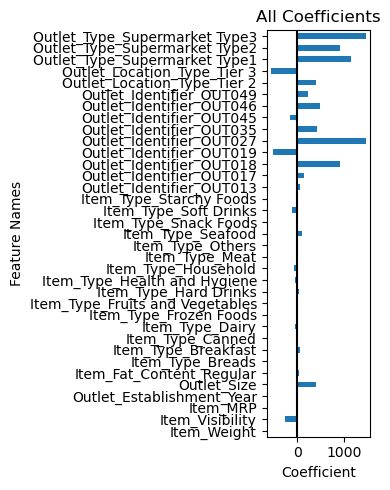

In [40]:
fig, ax = plt.subplots()
plot_coeffs(coeffs)
fig.tight_layout();
fig.savefig('Images/All Coefficients.png', dpi = 300)

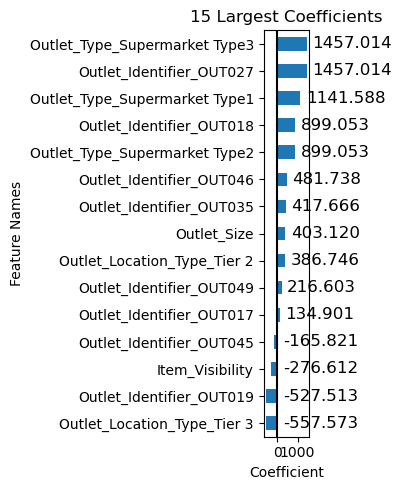

In [41]:
fig, ax = plt.subplots()
ax = plot_coeffs(coeffs, top_n = 15, annotate = True)
fig.tight_layout();
fig.savefig('Images/Top 15 Largest Coefficients.png', dpi = 300)

#### Select the top 3 most impactful features and interpret their coefficients

In [42]:
coeffs.sort_values(ascending = False).head(3)

Outlet_Type_Supermarket Type3   1,457.01
Outlet_Identifier_OUT027        1,457.01
Outlet_Type_Supermarket Type1   1,141.59
dtype: float64

- Outlet_Type_Supermarket Type 3, Outlet_Identifier_OUT027, and Outlet_Type_Supermarket Type 1 had the most impact on the model.
    - Outlet_Type_Supermarket Type 3:  Being in the Type 3 Supermarket group increases the item outlet sales by 1457.01.
    - Outlet_Identifier_OUT027:  Being in the OUT027 group (being sold at OUT027) increases the item outlet sales by 1457.01.
    - Outlet_Type_Supermarket Type 1:  Being in the Type 1 Supermarket group increases the item outlet sales by 1141.59.

### Save the figure as a .png file inside the repository

- All figures are saved as .png files in the repository.

## Tree-Based Model

### Fit and evaluate the tree-based regression model using the dataframe X_train and X_test data

In [43]:
#instantiate and fit a decision tree regressor model
dec_tree = DecisionTreeRegressor(random_state = SEED)
dec_tree.fit(X_train_df, y_train)

DecisionTreeRegressor(random_state=321)

In [44]:
#evaluate the training and test data using R-squared and RMSE
evaluate_regression(dec_tree, X_train_df, y_train, X_test_df, y_test)

Training Data:	R^2= 1.00	RMSE= 0.00
Test Data:	R^2= 0.19	RMSE= 1576.13


- The model accounts for 100% of the variation in the training data using the features.
- The model accounts for 19% of the variation in the testing data using the features.  The model is overfitting on the training data
- The RMSE for the training data is 0, and the RMSE for the testing data is 1576.13 so the model is making some large errors on the testing data.

### Extract and visualize the feature importances that the model determined

#### Extract feature importances

In [45]:
importances = get_importances(dec_tree)

#### Plot feature importances

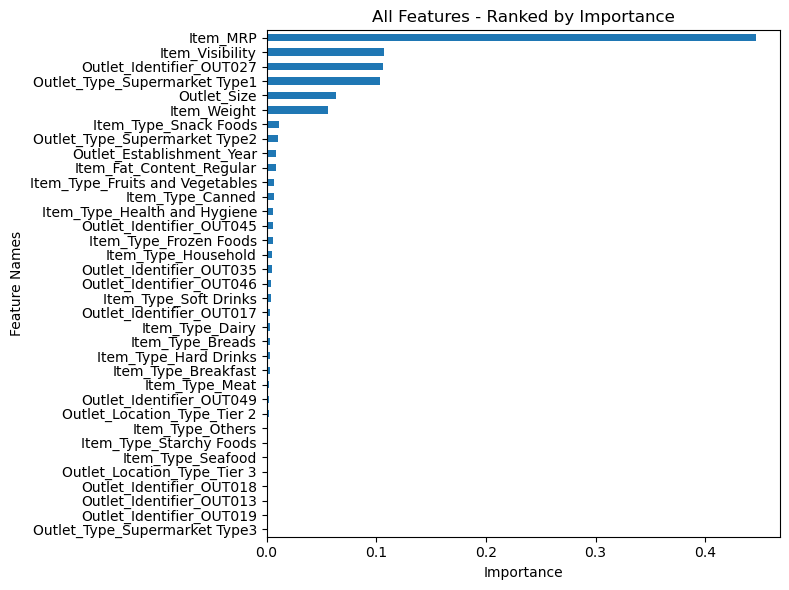

In [46]:
fig, ax = plt.subplots()
plot_importance(importances)
fig.tight_layout();
fig.savefig('Images/All Feature Importances.png', dpi = 300)

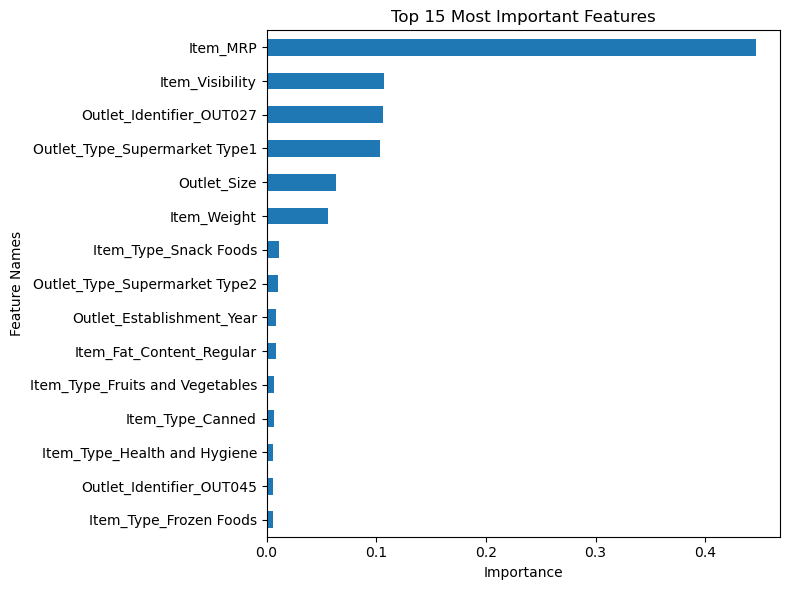

In [47]:
fig, ax = plt.subplots()
plot_importance(importances, top_n = 15)
fig.tight_layout();
fig.savefig('Images/Top 15 Most Important Features.png', dpi = 300)

#### Identify the top 5 most important features

In [48]:
importances.sort_values(ascending = False).head()

Item_MRP                        0.45
Item_Visibility                 0.11
Outlet_Identifier_OUT027        0.11
Outlet_Type_Supermarket Type1   0.10
Outlet_Size                     0.06
Name: Feature Importance, dtype: float64

- The 5 most important features were Item_MRP, Item_Visibility, Outlet_Identifier_OUT027, Outlet_Type_Supermarket Type1, and Outlet_Size.
- These features are the most helpful features for this tree-based model to separate the data for predicting the item outlet sales.

### Save the figure as a .png file inside the repository

- All figures are saved as .png files in the repository.

## Serialize the Best Models with Joblib

### Save the following key: value pairs as a dictionary in a joblib file named "best-models.joblib"
- "preprocessor": preprocessing column transformer
- "X_train": training features.
- "X_test": test features.
- "y_train": training target.
- "y_test": test target.
- "LinearRegression": best linear regression
- "DecisionTreeRegressor": best tree-based model

In [49]:
export = {'preprocessor': preprocessor,
          'X_train':X_train_df,
          'y_train': y_train,
          'X_test':X_test_df,
          'y_test': y_test,
          'LinearRegression': lin_reg,
          'DecisionTreeRegressor': dec_tree}
joblib.dump(export, 'best-models.joblib')

['best-models.joblib']

#### Save the joblib file inside the repository

- The joblib file is saved in the repository.